In [3]:
import cv2
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def setup_video(video_path, duration):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    num_frames = int(duration * fps)
    frames = [None] * num_frames
    
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frames[i] = frame
    
    cap.release()
    return frames, fps

In [3]:
def process_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), cv2.BORDER_DEFAULT)
    _, thresh = cv2.threshold(blur,220, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    midpoints = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx, cy = int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])
            cv2.drawContours(frame, [cnt], -1, (0, 255, 0), 2)
            cv2.circle(frame, (cx, cy), 2, (0, 0, 255), -1)
            midpoints.append((cx, cy))
    return midpoints

In [28]:
# Initialize variables
angles = {
    'hip': [], 'knee': [], 'ankle': [],
    'trunk': [], 'thigh': [], 'leg': [], 'feet': []
}

# Setup
name = input("Enter name: ")
plane = input("Enter plane(r for right, l for left): ")
video_path = rf"E:\Gait Analysis NMH\Video\{name.capitalize()}{plane.capitalize()}.mp4"
user_input = input("Press 'a' for simpler method or 'b' for exceptional method: ")
frames, fps = setup_video(video_path, 30)

# Create and open a CSV file for writing
csv_file_path = rf"E:\Gait Analysis NMH\CSV_raw\{name.capitalize()}{plane.capitalize()}.csv"
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Write header
    csv_writer.writerow(['Frame', 'Trunk', 'Thigh', 'Leg', 'Foot', 'Hip', 'Knee', 'Ankle'])

    frame_index = 1
    while frame_index < len(frames):
        frame = frames[frame_index].copy()
        midpoints = process_frame(frame)
        
        # Initialize default empty values for this frame
        current_frame_data = [frame_index, '', '', '', '', '', '', '']
        
        # Sort midpoints
        sorted_y = sorted(midpoints, key=lambda x: x[1])
        if user_input == 'a':
            last_two = sorted_y[-2:]
            if plane == 'l':
                sorted_x = sorted(last_two, reverse=True, key=lambda x: x[0])
            elif plane == 'r':
                sorted_x = sorted(last_two, key=lambda x: x[0])
            final_points = sorted_y[:-2] + sorted_x
        elif user_input == 'b':
            final_points = sorted_y[:-2] + sorted_y[-2:]

        # Process angles if we have enough points
        if len(final_points) == 5:
            # Calculate slopes
            slopes = []
            for i in range(4):
                x1, y1 = final_points[i]
                x2, y2 = final_points[i + 1]
                slope = (y2 - y1) / (x2 - x1) if x2 != x1 else np.inf
                slopes.append(slope)
                cv2.line(frame, final_points[i], final_points[i + 1], (0, 0, 255), 2)

            # Calculate angles
            m1, m2, m3, m4 = slopes
            angles_rad = [math.atan(m) for m in slopes]
            
            # Convert to degrees with conditions
            if plane.lower() == 'r':
                angD_tr = -math.degrees(angles_rad[0]) if m1 < 0 else 180 - math.degrees(angles_rad[0])
                angD_th = -math.degrees(angles_rad[1]) if m2 < 0 else 180 - math.degrees(angles_rad[1])
                angD_lg = -math.degrees(angles_rad[2]) if m3 < 0 else 180 - math.degrees(angles_rad[2])
                
                if user_input == 'a':
                    angD_ft = 180 - math.degrees(angles_rad[3])
                else:
                    angD_ft = -math.degrees(angles_rad[3]) if m4 < 0 else 180 - math.degrees(angles_rad[3])

            elif plane.lower() == 'l':
                angD_tr = 180 + math.degrees(angles_rad[0]) if m1 < 0 else math.degrees(angles_rad[0])
                angD_th = 180 + math.degrees(angles_rad[1]) if m2 < 0 else math.degrees(angles_rad[1])
                angD_lg = 180 + math.degrees(angles_rad[2]) if m3 < 0 else math.degrees(angles_rad[2])
                
                if user_input == 'a':
                    angD_ft = 180 + math.degrees(angles_rad[3])
                else:
                    angD_ft = 180 + math.degrees(angles_rad[3]) if m4 < 0 else math.degrees(angles_rad[3])
            else:
                print("Invalid plane")
                break

            # Calculate joint angles
            hip_angle = round(angD_th - angD_tr, 2)
            knee_angle = round(angD_th - angD_lg, 2)
            ankle_angle = round(angD_ft - angD_lg - 90, 2)

            # Store angles
            angles['trunk'].append(angD_tr)
            angles['thigh'].append(angD_th)
            angles['leg'].append(angD_lg)
            angles['feet'].append(angD_ft)
            angles['hip'].append(hip_angle)
            angles['knee'].append(knee_angle)
            angles['ankle'].append(ankle_angle)

            # Update current frame data with calculated values
            current_frame_data = [
                frame_index,
                round(angD_tr, 2),
                round(angD_th, 2),
                round(angD_lg, 2),
                round(angD_ft, 2),
                hip_angle,
                knee_angle,
                ankle_angle
            ]

            # Display angles on frame
            angle_texts = [
                (f"Trunk Angle: {angD_tr:.2f}", 70),
                (f"Thigh Angle: {angD_th:.2f}", 90),
                (f"Leg Angle: {angD_lg:.2f}", 110),
                (f"Feet Angle: {angD_ft:.2f}", 130)
            ]
            
            for text, y_pos in angle_texts:
                cv2.putText(frame, text, (30, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 1)
        else:
            # Display message on frame when not enough points
            cv2.putText(frame, "Insufficient points detected", (30, 70), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1)

        # Write the current frame's data to CSV (whether we got data or not)
        csv_writer.writerow(current_frame_data)

        # Display frame number
        cv2.putText(frame, f"Frame: {frame_index}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1)
        cv2.imshow('Frame', frame)

        # Handle key actions
        key = cv2.waitKey(0) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('f'):
            frame_index = (frame_index + 1) % len(frames)
        elif key == ord('b'):
            frame_index = (frame_index - 1) % len(frames)

cv2.destroyAllWindows()

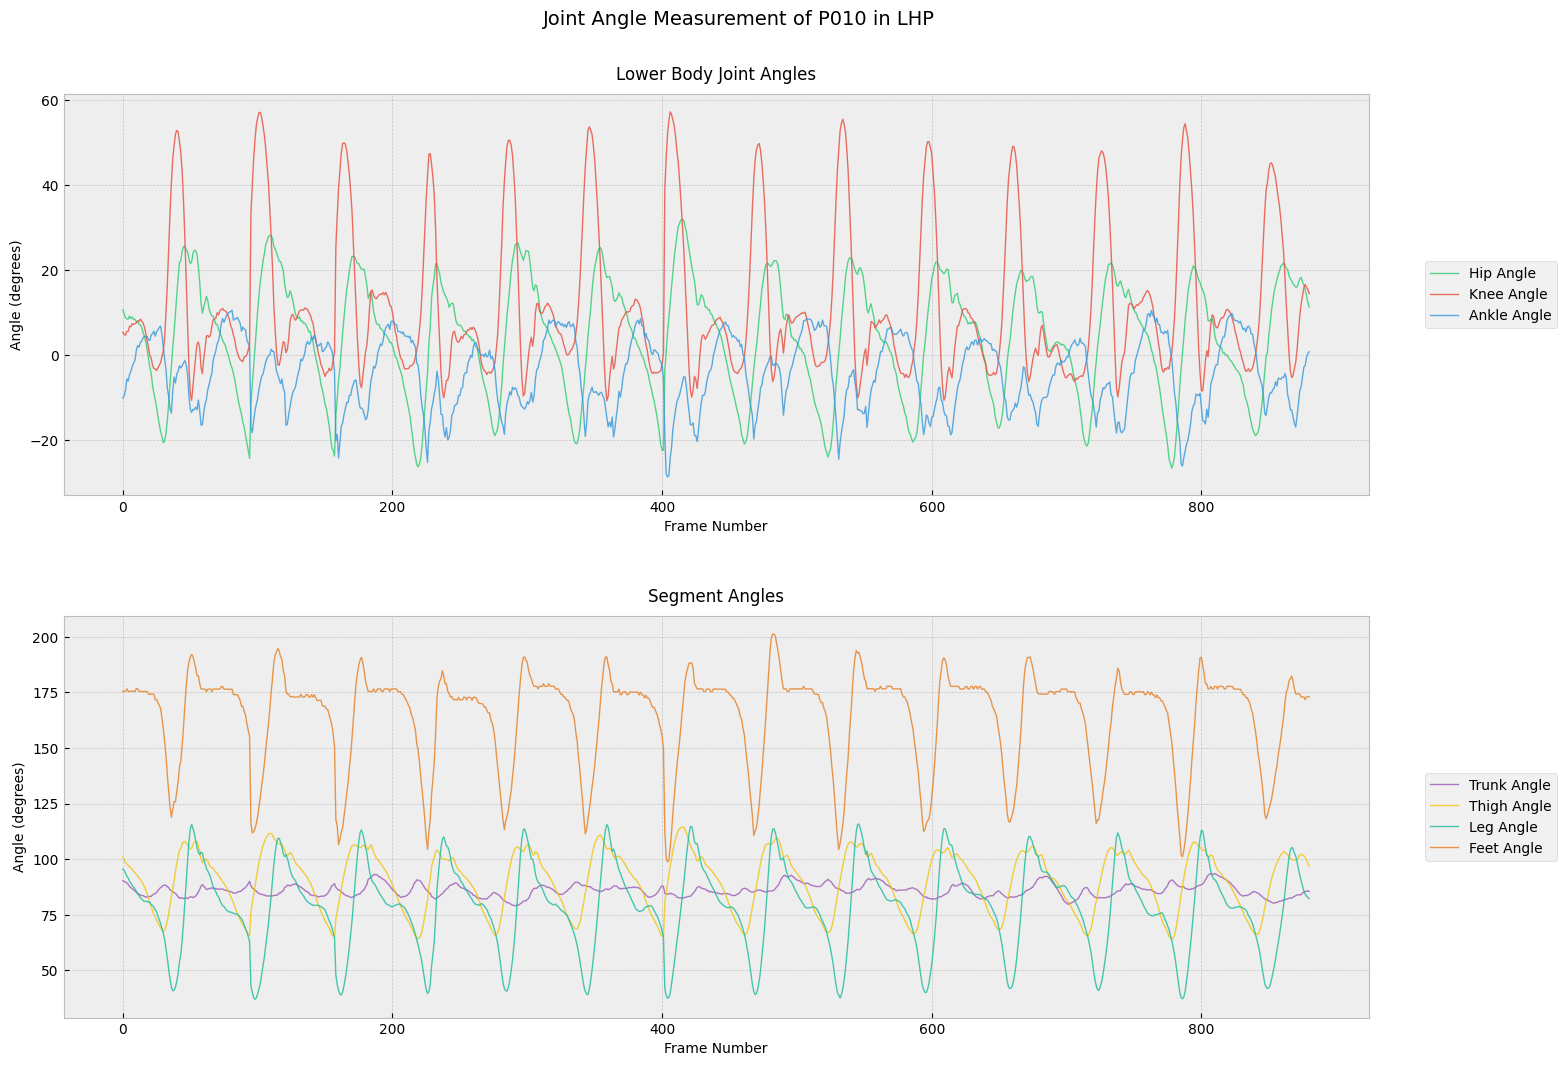

In [23]:
# Set figure style and size
plt.style.use('bmh')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

# Color palette for better distinction
colors = ['#2ecc71', '#e74c3c', '#3498db']

# Joint angles plot with enhanced styling
for angle, color in zip(['hip', 'knee', 'ankle'], colors):
    ax1.plot(angles[angle], label=f"{angle.title()} Angle", 
             color=color, linewidth=1, alpha=0.8)

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlabel('Frame Number', fontsize=10)
ax1.set_ylabel('Angle (degrees)', fontsize=10)
ax1.set_title('Lower Body Joint Angles', fontsize=12, pad=10)
ax1.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))

# Segment angles plot with enhanced styling
colors = ['#9b59b6', '#f1c40f', '#1abc9c', '#e67e22']
for angle, color in zip(['trunk', 'thigh', 'leg', 'feet'], colors):
    ax2.plot(angles[angle], label=f"{angle.title()} Angle", 
             color=color, linewidth=1, alpha=0.8)

ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlabel('Frame Number', fontsize=10)
ax2.set_ylabel('Angle (degrees)', fontsize=10)
ax2.set_title('Segment Angles', fontsize=12, pad=10)
ax2.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))

# Overall figure styling
fig.suptitle(f'Joint Angle Measurement of {name.capitalize()} in {plane.capitalize()}HP', 
             fontsize=14, y=0.95)
plt.subplots_adjust(hspace=0.3, right=0.85)
plt.show()